In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import skimage
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

import os
from skimage import io
from tqdm import tqdm

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression

# Cats/Dogs Classification:

We will use Restricted Boltzmann Machines to build a classifier for images of cats and dogs.

# Image Import with SKImage and OS

In [2]:
#Set height/width for image resizing, create a Boolean to check whether import is already done for current image size:

missingdataset = False
image_size = 25

In [3]:
labeled_data = 'dogscats/train'
unlabeled_data = 'dogscats/test'

## Example Cat image:

In [4]:
image = color.rgb2gray(io.imread(labeled_data+'/cat.7.jpg'))

In [5]:
image.shape

(499, 495)

In [6]:
image_resized = resize(image, (25, 25), mode='reflect')

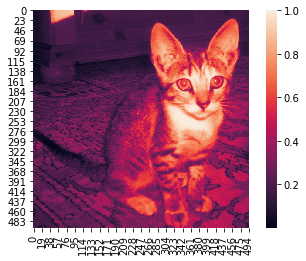

In [7]:
sns.heatmap(image, square=True)

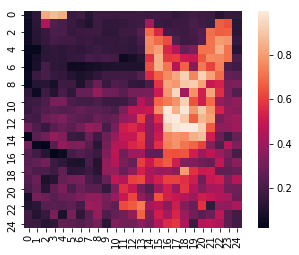

In [8]:
sns.heatmap(image_resized, square=True)

## Functions for Importing Images with Labels Applied:

In [9]:
# Use "cat" as 1, "dog" as 0

def label_image(image):
    animal_label = image.split('.')[-3]
    if animal_label == 'cat':
        return 1
    elif animal_label == 'dog':
        return 0

In [10]:
# Resize each image, then save to a .npy file with a label corresponding to image size:

def import_resize_image(image_size=image_size):
    data = []
    for image in tqdm(os.listdir(labeled_data)):
        label = label_image(image)
        path = os.path.join(labeled_data, image)
        image_number = image.split('.')[0]
        image = resize(color.rgb2gray(io.imread(labeled_data +'/' + image)), (image_size, image_size), mode='constant')
        data.append([np.array(image), np.array(label)])
    np.save('dog_cat_data_{}.npy'.format(image_size), data)

In [11]:
try:
    dataset = np.load('dog_cat_data_{}.npy'.format(image_size))
except FileNotFoundError:
    missingdataset = True

In [12]:
# If there is no .npy file of the correct size images in the directory, create one.

if missingdataset == True:
    train_data = import_resize_image()
else:
    pass

In [13]:
# Reshape 2-d arrays to 1-d:

dataset[:, 0] = [x.reshape(image_size**2) for x in dataset[:, 0]]

In [14]:
columnnames = np.arange((image_size**2)+1)

In [15]:
len(np.column_stack(list(zip(*dataset)))[0])

626

In [16]:
# Use pandas for easy data grouping:

df = pd.DataFrame([np.append(*row) for row in dataset], columns=list(columnnames))

In [17]:
X = df.drop([image_size**2], 1)

In [18]:
X.head()

0         1         2         3         4         5         6    \
0  0.173147  0.214450  0.270422  0.280092  0.163108  0.436000  0.718312   
1  0.425067  0.441745  0.445837  0.473985  0.467153  0.494996  0.562152   
2  0.408257  0.704821  0.751113  0.778264  0.746354  0.772884  0.763455   
3  0.100236  0.112418  0.113632  0.104182  0.102024  0.099357  0.120957   
4  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

        7         8         9      ...          615       616       617  \
0  0.736932  0.722358  0.794714    ...     0.300754  0.296190  0.116330   
1  0.636742  0.563758  0.517982    ...     0.365529  0.529610  0.582970   
2  0.757181  0.745506  0.609983    ...     0.507135  0.474001  0.468699   
3  0.107003  0.103718  0.126518    ...     0.551818  0.288701  0.287241   
4  1.000000  1.000000  1.000000    ...     1.000000  1.000000  1.000000   

        618       619       620       621       622       623       624  
0  0.141524  0.136381  0.156648  0.222031  0.120444  0.198742  0.214802  
1  0.588374  0.604392  0.550941  0.494771  0.357125  0.457173  0.316905  
2  0.471084  0.459836  0.436360  0.388043  0.351914  0.326879  0.283361  
3  0.285102  0.257133  0.292095  0.176477  0.119653  0.129355  0.150767  
4  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  

[5 rows x 625 columns]

In [103]:
X

0         1         2         3         4         5         6    \
0      0.173147  0.214450  0.270422  0.280092  0.163108  0.436000  0.718312   
1      0.425067  0.441745  0.445837  0.473985  0.467153  0.494996  0.562152   
2      0.408257  0.704821  0.751113  0.778264  0.746354  0.772884  0.763455   
3      0.100236  0.112418  0.113632  0.104182  0.102024  0.099357  0.120957   
4      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
5      0.418272  0.133590  0.536894  0.133529  0.129526  0.127618  0.128901   
6      0.774429  0.210066  0.268454  0.332298  0.157994  0.227058  0.302209   
7      0.946707  0.953629  0.951642  0.954848  0.955586  0.954449  0.959188   
8      0.103545  0.106220  0.082906  0.057818  0.045913  0.028314  0.026487   
9      0.562098  0.587840  0.582711  0.596633  0.584476  0.606369  0.639353   
10     0.152693  0.715330  0.074291  0.742611  0.757620  0.753242  0.717592   
11     0.367949  0.344800  0.340879  0.369518  0.444454  0.389910  0.390302   
12     1.000000  1.000000  0.535948  0.516471  0.516133  0.688992  0.623151   
13     0.592215  0.609627  0.611525  0.611525  0.607604  0.607015  0.590198   
14     0.257311  0.193964  0.245848  0.297330  0.297025  0.303799  0.299182   
15     0.997895  0.998661  0.998661  0.998661  0.997057  0.998661  0.999174   
16     0.911953  0.916227  0.884033  0.805327  0.635740  0.553418  0.485626   
17     0.131195  0.132554  0.127691  0.155092  0.156372  0.105448  0.406280   
18     0.192402  0.165927  0.149052  0.146894  0.170752  0.757457  0.810489   
19     0.653724  0.688022  0.726586  0.677695  0.488655  0.574894  0.726273   
20     0.998730  1.000000  1.000000  0.706140  1.000000  1.000000  1.000000   
21     0.221535  0.268084  0.288721  0.303477  0.293806  0.316611  0.308680   
22     0.299400  0.277792  0.290523  0.313506  0.325667  0.329269  0.304215   
23     0.292659  0.312334  0.340958  0.349585  0.385432  0.386844  0.394419   
24     0.037936  0.386557  0.483914  0.007529  0.060863  0.444211  0.482818   
25     0.454195  0.584203  0.624383  0.478369  0.375421  0.457240  0.487327   
26     0.611397  0.696181  0.827116  0.727023  0.707234  0.581671  0.684057   
27     0.292127  0.315262  0.218693  0.396689  0.402787  0.370630  0.384748   
28     1.000000  1.000000  0.955208  0.367565  0.332491  0.719267  0.373997   
29     0.355391  0.427103  0.260002  0.333519  0.375663  0.388585  0.482692   
...         ...       ...       ...       ...       ...       ...       ...   
24970  0.542352  0.506390  0.528416  0.526451  0.507911  0.533172  0.609709   
24971  0.119806  0.105251  0.103278  0.119595  0.123127  0.097720  0.109468   
24972  0.191918  0.254203  0.258223  0.200944  0.280233  0.290456  0.338404   
24973  0.289659  0.287194  0.204637  0.204427  0.198102  0.178869  0.174761   
24974  0.173670  0.177658  0.193732  0.200634  0.214173  0.230800  0.236761   
24975  0.043137  0.054902  0.066101  0.044768  0.114415  0.119054  0.134740   
24976  0.861883  0.837863  0.756419  0.881915  0.604710  0.767521  0.761763   
24977  0.427260  0.456907  0.480158  0.525020  0.589726  0.649589  0.717642   
24978  0.784801  0.100440  0.074513  0.129676  0.247629  0.256690  0.096188   
24979  0.305809  0.475939  0.465096  0.419056  0.379937  0.481922  0.454338   
24980  0.550682  0.565255  0.561517  0.567435  0.565517  0.571438  0.569438   
24981  0.391185  0.377962  0.375761  0.382158  0.472299  0.623213  0.672275   
24982  0.705831  0.723041  0.753395  0.746572  0.790415  0.791693  0.802156   
24983  0.463838  0.489076  0.506096  0.531586  0.543978  0.557952  0.546253   
24984  0.059918  0.063839  0.057565  0.071682  0.079525  0.071682  0.075604   
24985  0.502730  0.534962  0.497683  0.308293  0.310918  0.321310  0.340832   
24986  0.661270  0.639593  0.646644  0.603762  0.641123  0.716698  0.628183   
24987  0.798235  0.782549  0.786874  0.770784  0.788443  0.799109  0.828875   
24988  0.796935  0.735206  0.671802  0.650404  0.724723  0.757

In [ ]:
cvscore.mean()

In [19]:
Y = df[image_size**2].apply(lambda x: int(x))

In [20]:
Y.head()

0    0
1    1
2    0
3    1
4    1
Name: 625, dtype: int64

All of the data was from the "train" set, but the "test" set is not labeled, so we'll make a separate test set from the "training" data.

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.333)

# Bernoulli Restricted Boltzmann Machine + Logistic Regression

## Initial Model (Parameters copied from Digits example)

https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py

In [131]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000,
                              multi_class='multinomial', C=6000)

In [132]:
rbm = BernoulliRBM(n_components=625, learning_rate = 0.004, n_iter = 20, verbose=True)

In [133]:
rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [134]:
rbm_features_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -389.56, time = 5.97s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -380.52, time = 7.06s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -378.54, time = 6.87s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -376.17, time = 6.57s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -370.90, time = 6.51s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -370.20, time = 6.53s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -367.85, time = 6.53s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -367.94, time = 6.54s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -367.80, time = 6.52s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -365.07, time = 6.50s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -366.60, time = 6.51s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -364.17, time = 6.50s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -364.66, time = 6.51s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -360.80, time = 6.52s
[BernoulliRBM] 

Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.004, n_components=625, n_iter=20,
       random_state=None, verbose=True)), ('logistic', LogisticRegression(C=6000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

### Results:

In [135]:
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (classification_report(Y_test, Y_pred)))

Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.63      0.66      0.64      4198
          1       0.64      0.60      0.62      4127

avg / total       0.63      0.63      0.63      8325




In [130]:
rbm_features_classifier.score(X_test, Y_test)

0.632912912912913

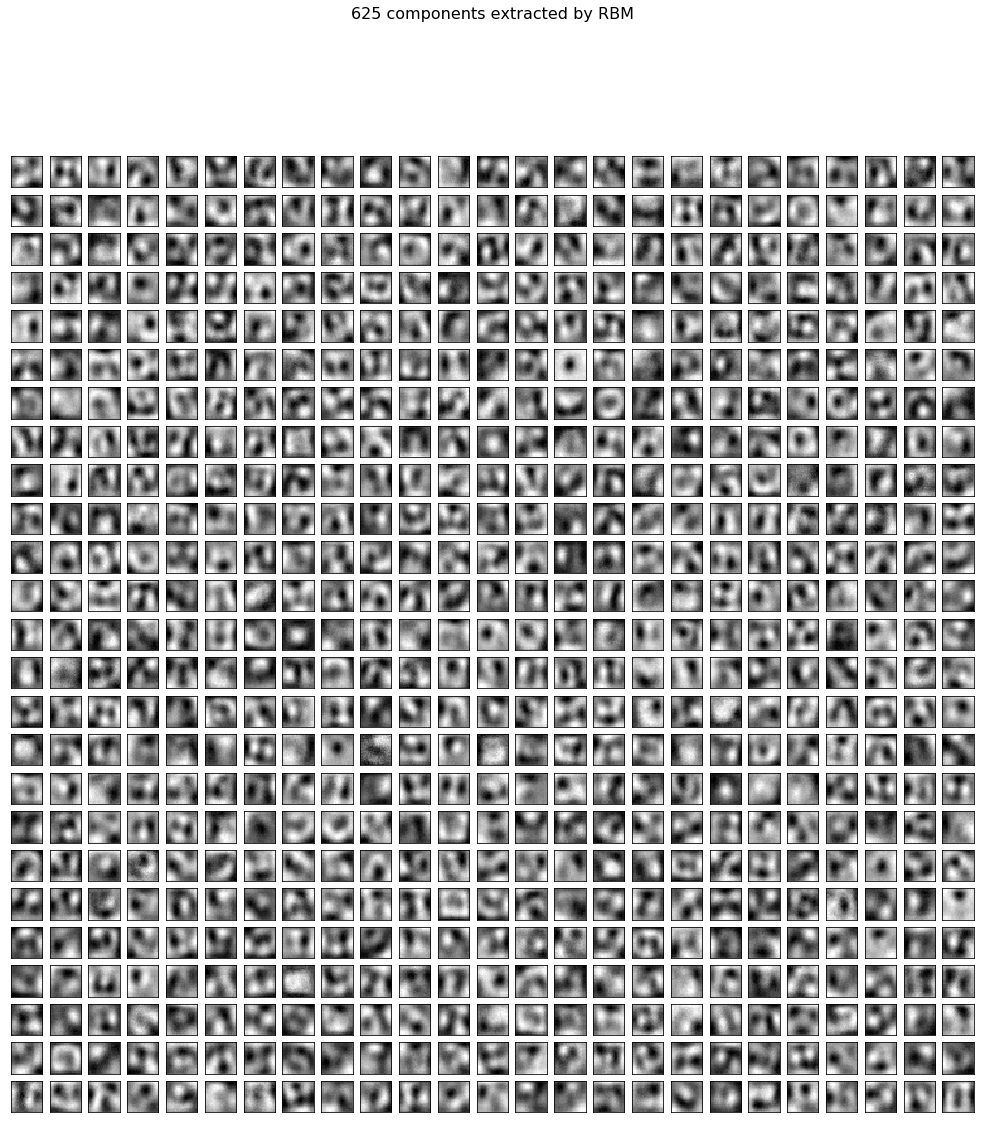

In [122]:
plt.figure(figsize=(16, 16))
for i, comp in enumerate(rbm.components_):
    plt.subplot(25, 25, i + 1)
    plt.imshow(comp.reshape((25, 25)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('625 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

## Visualizing the Components:

Each component contains light and dark patterns that match features of the image. There are a lot of components with two dark blobs in a horizontal arrangement, some with a third blob below and between; these probably correspond to eyes, ears, and noses. Many of the images contain more than just the face of the dog or cat, though, or they are a side view. Some pictures contain humans.

## Testing Hyperparameters with GridSearchCV

In [89]:
"""logistic = LogisticRegression(solver='lbfgs', max_iter=10000,
                              multi_class='multinomial')"""

"logistic = LogisticRegression(solver='lbfgs', max_iter=10000,\n                              multi_class='multinomial')"

In [90]:
"""rbm = BernoulliRBM(n_components=625, n_iter = 20, verbose=True)"""

'rbm = BernoulliRBM(n_components=625, n_iter = 20, verbose=True)'

In [91]:
"""rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])"""

"rbm_features_classifier = Pipeline(\n    steps=[('rbm', rbm), ('logistic', logistic)])"

In [92]:
"""param_grid = {
    'rbm__learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008], 'logistic__C': [1000, 6000]
}

rbmgridsearch = GridSearchCV(rbm_features_classifier, param_grid, cv=3, return_train_score=True)
rbmgridsearch.fit(X_train, Y_train)"""

"param_grid = {\n    'rbm__learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008], 'logistic__C': [1000, 6000]\n}\n\nrbmgridsearch = GridSearchCV(rbm_features_classifier, param_grid, cv=3, return_train_score=True)\nrbmgridsearch.fit(X_train, Y_train)"

In [93]:
"""print('Best parameters found:\n', rbmgridsearch.best_params_)

# All results
means = rbmgridsearch.cv_results_['mean_test_score']
stds = rbmgridsearch.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rbmgridsearch.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))"""

'print(\'Best parameters found:\n\', rbmgridsearch.best_params_)\n\n# All results\nmeans = rbmgridsearch.cv_results_[\'mean_test_score\']\nstds = rbmgridsearch.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, rbmgridsearch.cv_results_[\'params\']):\n    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))'

In [94]:
"""pd.DataFrame(rbmgridsearch.cv_results_).to_csv('RBMGridSearch.csv')"""

"pd.DataFrame(rbmgridsearch.cv_results_).to_csv('RBMGridSearch.csv')"

In [95]:
pd.read_csv('RBMGridSearch.csv', index_col=0)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      166.170683      6.162291         0.074409        0.000831   
1      206.384484     46.198389         0.075230        0.001372   
2      756.666104    809.993702         0.086333        0.016784   
3      186.326225      4.083010         0.074626        0.000526   
4      355.791237    255.712938         0.074444        0.001894   
5      176.752554      2.856598         0.075892        0.001403   
6      172.770491     10.037981         0.074348        0.000368   
7      183.680348     15.616514         0.086932        0.018758   
8      180.010722      3.461491         0.074358        0.000673   
9      329.603310    200.319529         0.079423        0.006579   
10     184.314661      4.137626         0.075514        0.001714   
11     224.506331     46.681954         0.073785        0.000266   
12     188.117192      1.299763         0.074051        0.000305   
13     460.206417    385.384534         0.073928        0.000047   
14     193.618428      3.322004         0.074352        0.000397   
15     190.112841      3.699461         0.074555        0.000886   

    param_logistic__C  param_rbm__learning_rate  \
0                1000                     0.001   
1                1000                     0.002   
2                1000                     0.003   
3                1000                     0.004   
4                1000                     0.005   
5                1000                     0.006   
6                1000                     0.007   
7                1000                     0.008   
8                6000                     0.001   
9                6000                     0.002   
10               6000                     0.003   
11               6000                     0.004   
12               6000                     0.005   
13               6000                     0.006   
14               6000                     0.007   
15               6000                     0.008   

                                               params  split0_test_score  \
0   {'logistic__C': 1000, 'rbm__learning_rate': 0....           0.619896   
1   {'logistic__C': 1000, 'rbm__learning_rate': 0....           0.626012   
2   {'logistic__C': 1000, 'rbm__learning_rate': 0....           0.621155   
3   {'logistic__C': 1000, 'rbm__learning_rate': 0....           0.637345   
4   {'logistic__C': 1000, 'rbm__learning_rate': 0....           0.640403   
5   {'logistic__C': 1000, 'rbm__learning_rate': 0....           0.639863   
6   {'logistic__C': 1000, 'rbm__learning_rate': 0....           0.638784   
7   {'logistic__C': 1000, 'rbm__learning_rate': 0....           0.635366   
8   {'logistic__C': 6000, 'rbm__learning_rate': 0....           0.621335   
9   {'logistic__C': 6000, 'rbm__learning_rate': 0....           0.625112   
10  {'logistic__C': 6000, 'rbm__learning_rate': 0....           0.634647   
11  {'logistic__C': 6000, 'rbm__learning_rate': 0....           0.628890   
12  {'logistic__C': 6000, 'rbm__learning_rate': 0....           0.628350   
13  {'logistic__C': 6000, 'rbm__learning_rate': 0....           0.631768   
14  {'logistic__C': 6000, 'rbm__learning_rate': 0....           0.631768   
15  {'logistic__C': 6000, 'rbm__learning_rate': 0....           0.643101   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.608672           0.611551         0.613373        0.004760   
1            0.616769           0.624325         0.622369        0.004019   
2            0.621626           0.637639         0.626807        0.007662   
3            0.615149           0.631882         0.628126        0.009443   
4            0.623786           0.643037         0.635742        0.008522   
5            0.624505           0.637819         0.634063        0.006809   
6            0.625225           0.637639         0.633883        0.006140   
7            0.627024           0.646815         0.636402        0.008

Best parameter set in grid: C=1000, Learning rate = 0.008.

## Adjusted Bernoulli RBM + Logistic Regression:

In [123]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000,
                              multi_class='multinomial', C=1000)

In [124]:
rbm = BernoulliRBM(n_components=625, learning_rate = 0.008, n_iter = 20, verbose=True)

In [125]:
rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [126]:
rbm_features_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -382.05, time = 6.27s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -378.68, time = 7.12s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -377.29, time = 6.62s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -371.47, time = 6.65s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -369.25, time = 6.70s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -369.76, time = 7.23s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -366.74, time = 6.66s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -366.77, time = 6.56s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -363.91, time = 7.20s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -365.35, time = 6.71s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -364.33, time = 6.59s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -361.30, time = 6.54s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -365.81, time = 7.60s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -360.78, time = 6.58s
[BernoulliRBM] 

Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.008, n_components=625, n_iter=20,
       random_state=None, verbose=True)), ('logistic', LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

### Results:

In [127]:
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (classification_report(Y_test, Y_pred)))

Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.62      0.68      0.65      4198
          1       0.64      0.58      0.61      4127

avg / total       0.63      0.63      0.63      8325




In [130]:
rbm_features_classifier.score(X_test, Y_test)

0.632912912912913

This doesn't seem to have changed the output scores significantly.

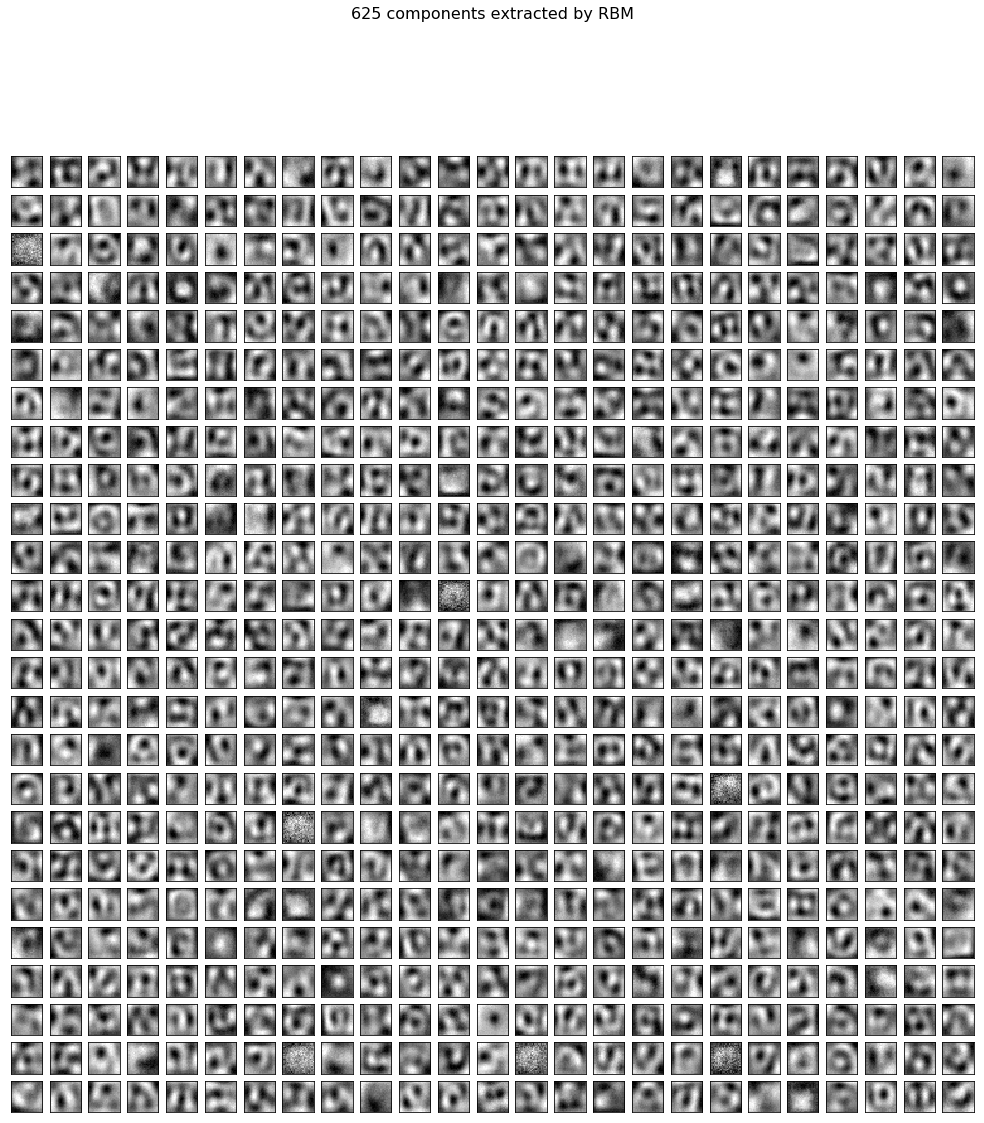

In [128]:
plt.figure(figsize=(16, 16))
for i, comp in enumerate(rbm.components_):
    plt.subplot(25, 25, i + 1)
    plt.imshow(comp.reshape((25, 25)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('625 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

# MLPClassifier

## MLP1

In [41]:
mlp1 = MLPClassifier(hidden_layer_sizes=(image_size**2,))

In [42]:
mlp1.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(625,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [43]:
mlp1.score(X_train, Y_train)

0.9612593703148425

In [44]:
Y_pred_train = mlp1.predict(X_train)
pd.crosstab(Y_pred_train, Y_train)

625       0     1
row_0            
0      7672    16
1       630  8357

In [45]:
mlp1.score(X_test, Y_test)

0.6172972972972973

In [46]:
Y_pred_test = mlp1.predict(X_test)
pd.crosstab(Y_pred_test, Y_test)

625       0     1
row_0            
0      1863   851
1      2335  3276

In [47]:
print(classification_report(Y_test, Y_pred_test))

             precision    recall  f1-score   support

          0       0.69      0.44      0.54      4198
          1       0.58      0.79      0.67      4127

avg / total       0.64      0.62      0.61      8325



## Testing Hyperparameters with GridSearchCV

In [48]:
"""parameter_space = {
    'hidden_layer_sizes': [(625,), (625, 125), (1000,), (1000, 625)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001],
}

mlp = MLPClassifier(max_iter=250, random_state=28)



mlpgridsearch = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, return_train_score=True)
mlpgridsearch.fit(X_train, Y_train)
# Nonconverngence warnings are raised for sgd."""

"parameter_space = {\n    'hidden_layer_sizes': [(625,), (625, 125), (1000,), (1000, 625)],\n    'activation': ['logistic', 'relu'],\n    'solver': ['sgd', 'adam'],\n    'alpha': [0.0001, 0.001],\n}\n\nmlp = MLPClassifier(max_iter=250, random_state=28)\n\n\n\nmlpgridsearch = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, return_train_score=True)\nmlpgridsearch.fit(X_train, Y_train)\n# Nonconverngence warnings are raised for sgd."

In [49]:
"""print('Best parameters found:\n', mlpgridsearch.best_params_)

# All results
means = mlpgridsearch.cv_results_['mean_test_score']
stds = mlpgridsearch.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mlpgridsearch.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))"""

'print(\'Best parameters found:\n\', mlpgridsearch.best_params_)\n\n# All results\nmeans = mlpgridsearch.cv_results_[\'mean_test_score\']\nstds = mlpgridsearch.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, mlpgridsearch.cv_results_[\'params\']):\n    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))'

In [50]:
"""pd.DataFrame(mlpgridsearch.cv_results_)"""

'pd.DataFrame(mlpgridsearch.cv_results_)'

In [51]:
"""resultsdf.sort_values(by='rank_test_score').to_csv('mlpgridsearch.csv')"""

"resultsdf.sort_values(by='rank_test_score').to_csv('mlpgridsearch.csv')"

In [52]:
resultsdf = pd.read_csv('mlpgridsearch.csv', index_col=0)

SGD did not converge in 250 iterations.

## MLPClassifier 2

In [53]:
mlp2 = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(1000,))

In [54]:
mlp2.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [55]:
mlp2.score(X_train, Y_train)

0.9879460269865068

In [56]:
Y_pred_train = mlp2.predict(X_train)
pd.crosstab(Y_pred_train, Y_train)

625       0     1
row_0            
0      8277   176
1        25  8197

In [57]:
mlp2.score(X_test, Y_test)

0.6235435435435436

In [58]:
Y_pred_test = mlp2.predict(X_test)
pd.crosstab(Y_pred_test, Y_test)

625       0     1
row_0            
0      2763  1699
1      1435  2428

In [59]:
print(classification_report(Y_test, Y_pred_test))

             precision    recall  f1-score   support

          0       0.62      0.66      0.64      4198
          1       0.63      0.59      0.61      4127

avg / total       0.62      0.62      0.62      8325



In [60]:
cvscore = cross_val_score(mlp2, X, Y, cv=5)

In [61]:
cvscore

array([0.6354, 0.6312, 0.6418, 0.6302, 0.6408])

In [62]:
cvscore.mean()

0.63588

In [63]:
cvscore.std()

0.00476755702640254

# Conclusions:

A pipeline constructed from RBM and a logistic regression predictor is much faster than SKLearn's MLP Classifier. The MLP Classifier is, however, slightly more accurate, and has higher precision and recall for both classes (about 0.636 instead of 0.62), although visualizing individual components of the model is less straightforward.

This dataset is probably better suited for analysis using more advanced algorithms, such as TensorFlow.

# (EXTRA - Extra Layers of RBM + Logistic Regression)

In [64]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000,
                              multi_class='multinomial', C=6000)

In [65]:
rbm = BernoulliRBM(n_components=625, learning_rate = 0.004, n_iter = 20, verbose=True)

In [66]:
rbm2 = BernoulliRBM(n_components=625, learning_rate = 0.003, n_iter = 20, verbose=True)

In [67]:
rbm3 = BernoulliRBM(n_components=625, learning_rate = 0.001, n_iter = 20, verbose=True)

In [68]:
rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('rbm2', rbm2), ('rbm3', rbm3), ('logistic', logistic)])

In [69]:
rbm_features_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -386.84, time = 5.78s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -381.89, time = 6.60s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -372.80, time = 6.52s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -377.92, time = 6.59s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -378.03, time = 7.43s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -378.18, time = 9.25s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -371.12, time = 6.58s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -370.00, time = 6.59s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -379.25, time = 6.56s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -374.52, time = 6.54s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -374.76, time = 6.54s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -369.73, time = 6.54s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -373.33, time = 6.54s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -372.46, time = 6.56s
[BernoulliRBM] 

Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.04, n_components=625, n_iter=20,
       random_state=None, verbose=True)), ('rbm2', BernoulliRBM(batch_size=10, learning_rate=0.03, n_components=625, n_iter=20,
       random_state=None, verbose=True)), ('rbm3', BernoulliRBM(batch_size=10, l...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [70]:
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (classification_report(Y_test, Y_pred)))

Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.60      0.67      0.63      4198
          1       0.62      0.54      0.57      4127

avg / total       0.61      0.60      0.60      8325




## Scores did not improve with additional layer.

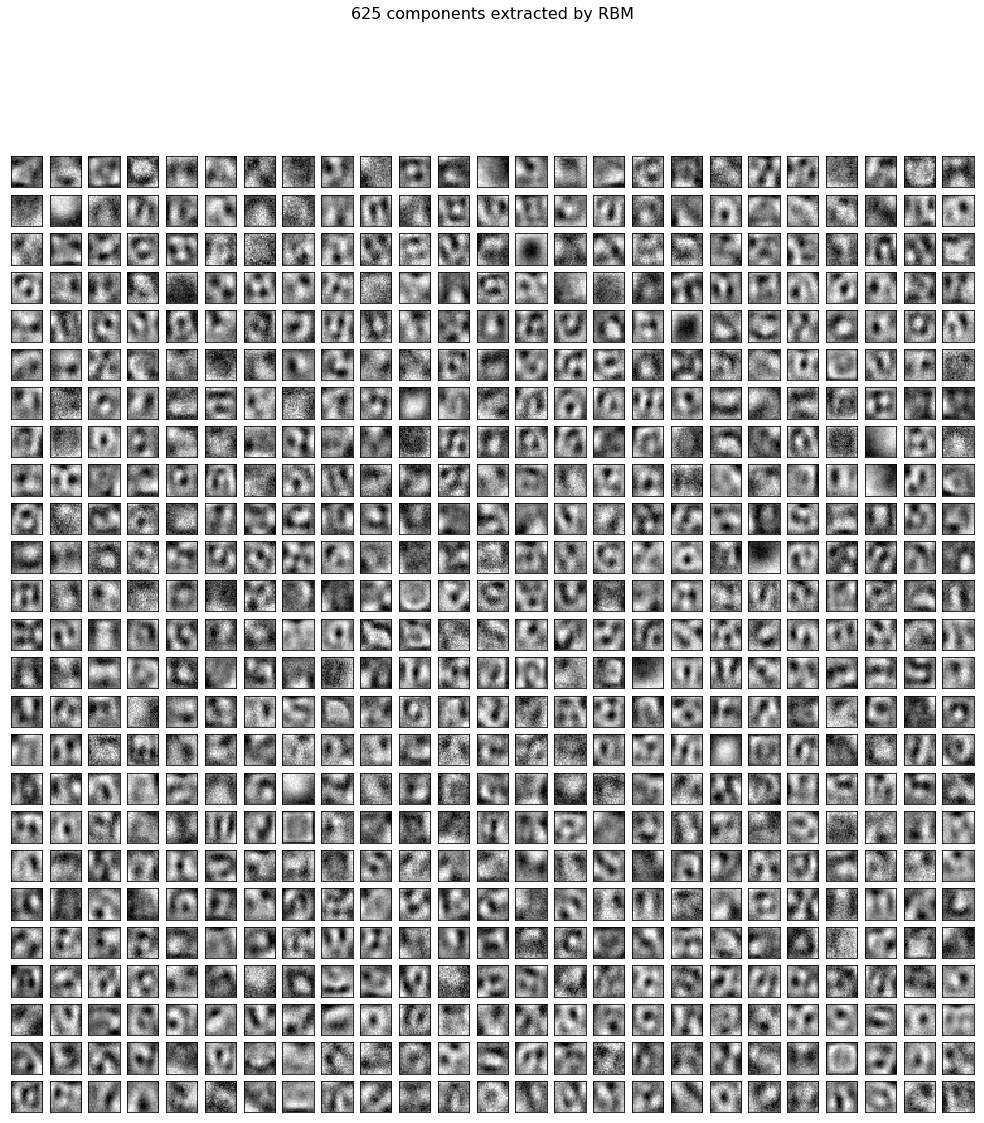

In [71]:
plt.figure(figsize=(16, 16))
for i, comp in enumerate(rbm.components_):
    plt.subplot(25, 25, i + 1)
    plt.imshow(comp.reshape((25, 25)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('625 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

## Second Hidden Layer Components:

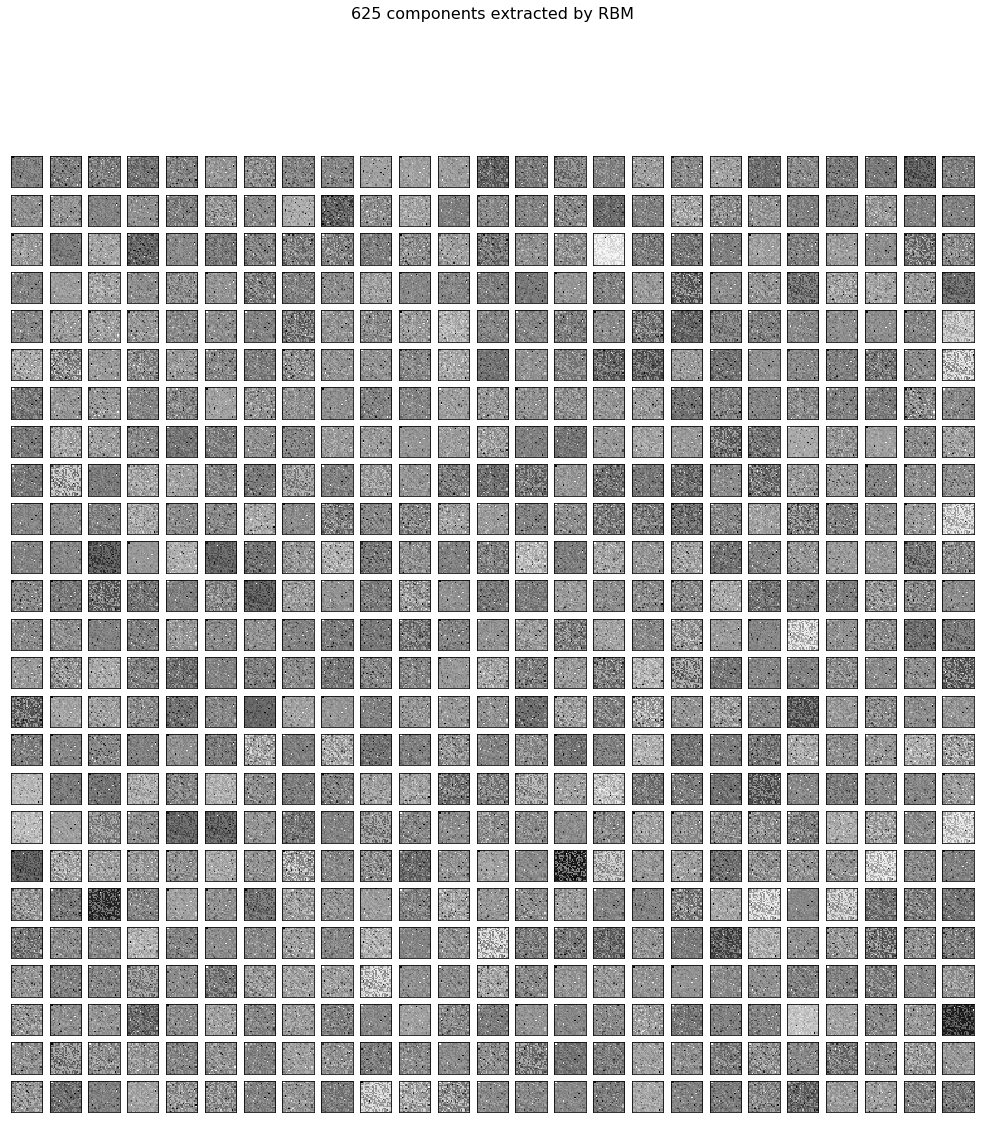

In [72]:
plt.figure(figsize=(16, 16))
for i, comp in enumerate(rbm2.components_):
    plt.subplot(25, 25, i + 1)
    plt.imshow(comp.reshape((25, 25)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('625 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

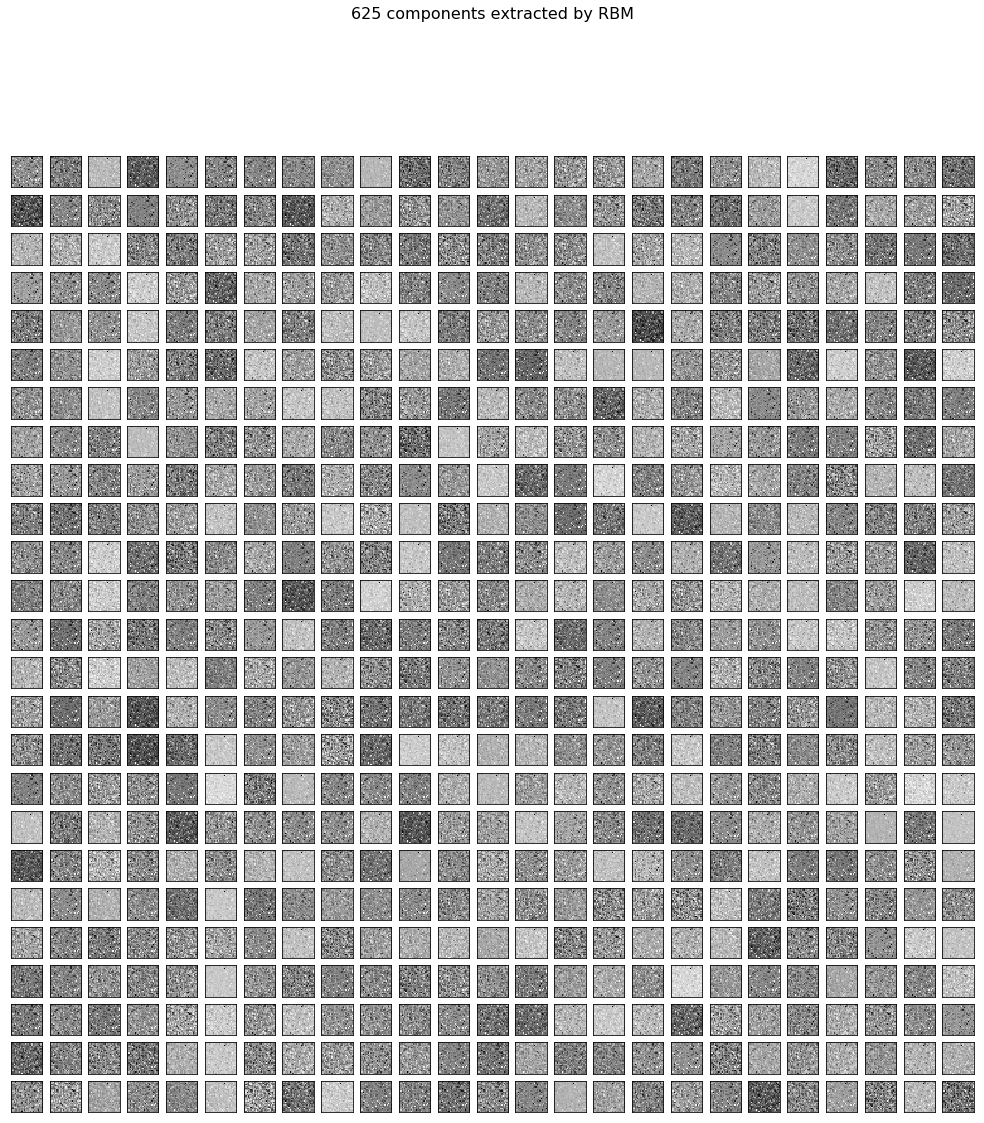

In [73]:
plt.figure(figsize=(16, 16))
for i, comp in enumerate(rbm3.components_):
    plt.subplot(25, 25, i + 1)
    plt.imshow(comp.reshape((25, 25)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('625 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()